# Summarize the MNIST dataset

Here we use the subsampler to draw a broadly representative subset of the MNIST digits dataset.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import sys
import time

sys.path.insert(0, '../src')
sys.path.insert(0, '../ext')

import subsample, herding, rptree, rff
%matplotlib inline

In [2]:
# Download and read MNIST data
import input_data
mnist = input_data.read_data_sets('../ext/MNIST')

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting ../ext/MNIST/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting ../ext/MNIST/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting ../ext/MNIST/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting ../ext/MNIST/t10k-labels-idx1-ubyte.gz


## Some example MNIST digits

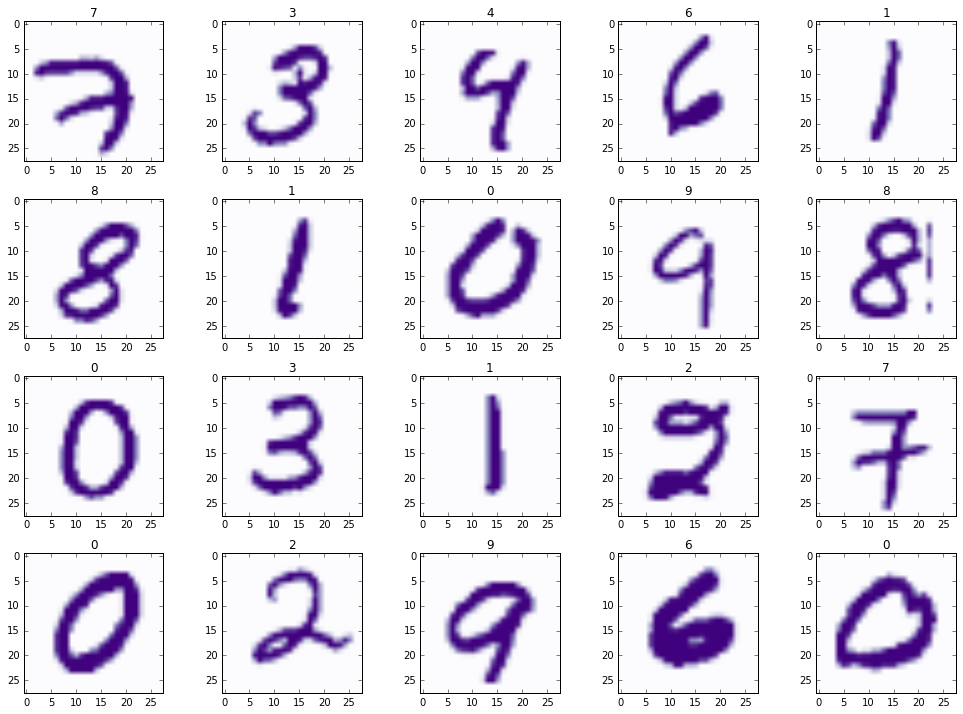

In [3]:
plt.figure(figsize=(14,10))
for i in xrange(20):
    plt.subplot(4,5,i+1)
    plt.imshow(mnist.train.images[i].reshape((28,28)))
    plt.title(mnist.train.labels[i])
    plt.set_cmap('Purples')
plt.tight_layout();

Let's select an optimized subset of 30 images from the first 50,000.

We'll use 500 random features, using a simple Gaussian kernel.

In [4]:
M = 30
N = 50000
D = 500

stream = mnist.train.images[:N]
initial_points = np.array(stream[:M])
lengthscale = rff.median_heuristic(initial_points[:100]);
phi = rff.RFF(D, initial_points.shape[1], lengthscale)

In [5]:
subsampler = subsample.TreeSubsampler(initial_points, phi)

start = time.time()
for i in xrange(M, len(stream)):
    if np.mod(i, N/10) == 1:
        print i-1
    subsampler.consider(stream[i])
stop = time.time()
print '%0.3f seconds' % (stop - start )


Size of subsample: 30
Number of items: 30
Each item dimension: 500
Tree depth: 2
Expected number of points at leaf: 7.5
5000
10000
15000
20000
25000
30000
35000
40000
45000
23.553 seconds


## Plot the selected images.

The selected digits show good variety across numbers (each of the digits 0--9 are represented), with distinct styles for each digit.

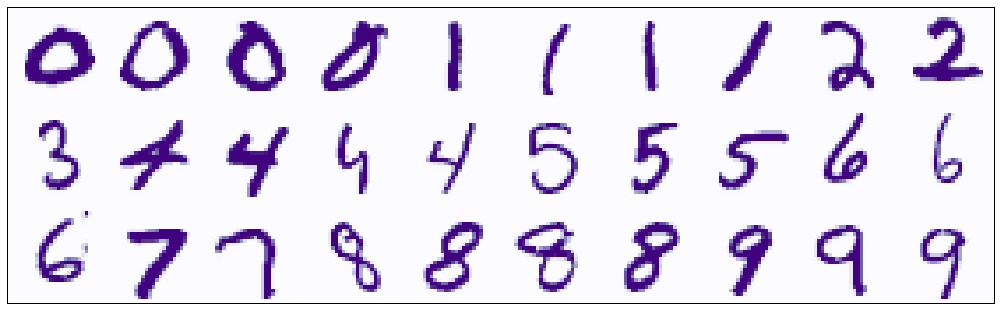

In [6]:

plt.figure(figsize=(14,5))
ordering = np.argsort(mnist.train.labels[subsampler.which])
# want height*1.618 = width, with height*width=M
height = int(np.sqrt(M/1.618))
width = M / height
try:
    assert height*width == M
except:
    height -= 1
    width = M/height
tiled = np.zeros((height*28,width*28))
for ix, j in enumerate(ordering):
    top = 28*int(ix / width)
    left = 28*np.mod(ix, width)
    tiled[top:top+28,left:left+28] = subsampler.points[j].reshape((28,28))

plt.imshow(tiled, interpolation="None")
plt.set_cmap('Purples')
plt.xticks([])
plt.yticks([])
plt.tight_layout();

In comparison, a randomly selected subsample of this size is not nearly as likely to even contain all the distinct digits!

In [7]:
print np.sum(mnist.train.labels[subsampler.which][:,None] == np.arange(10)[None,:],0)
print np.sum(mnist.train.labels[np.random.randint(0,N,M)][:,None] == np.arange(10)[None,:],0)

[4 4 2 1 4 3 3 2 4 3]
[7 6 0 3 2 3 3 3 0 3]
